In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split


events_num_identifier = "_15000_events"

subdir = "wSim_wReco"

path = "/nfs/dust/belle2/user/axelheim/MC_studies/my6modes/"
root_path = path + "rootfiles/" + subdir + '/'
file_pi = uproot.open((root_path + "pi_nTuples_mode1_10_events.root"))

#file_raw = uproot.open(root_path + "mode0_17_events.root")

In [2]:
file_pi["variables"].keys()


['__experiment__',
 '__run__',
 '__event__',
 '__candidate__',
 '__ncandidates__',
 '__weight__',
 'M',
 'x',
 'y',
 'z',
 'px',
 'py',
 'pz',
 'pt',
 'p',
 'E',
 'kaonID',
 'pionID',
 'isSignal',
 'mcErrors',
 'mcPDG',
 'mcPhotos',
 'mcPrimary',
 'mcInitial',
 'charge',
 'uniqueParticleIdentifier',
 'genMotherID',
 'genMotherPDG',
 'genMotherPDG__bo0__bc',
 'genMotherPDG__bo1__bc',
 'genMotherPDG__bo2__bc',
 'genMotherPDG__bo3__bc']

In [3]:
def conditions(s):
    label = -1
    if int(s['genPDG0']) == 0:
        label = 0 # background, cause not related to MC Particles
    elif (int(s['genPDG0']) == Bs_pdg) or (int(s['genPDG1']) == Bs_pdg) or (int(s['genPDG2']) == Bs_pdg) or (int(s['genPDG3']) == Bs_pdg):
        label = 2 # Bs
    elif (int(s['genPDG0']) == Hc_pdg) or (int(s['genPDG1']) == Hc_pdg) or (int(s['genPDG2']) == Hc_pdg) or (int(s['genPDG3']) == Hc_pdg):    
        label = 3 # Hc
    else: 
        label = 1 # X
    
    return label

In [4]:
Bs_pdg_list = [-511, 511,-521,-521,521,521]
Hc_pdg_list = [-411, 411, -411, -421, 411, 423]
dfs =[]
for mode in range(6):
    print("mode:",mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode,mode)
    
    Bs_pdg = Bs_pdg_list[mode]
    Hc_pdg = Hc_pdg_list[mode]
    
    nm = f"_nTuples_mode{mode}" + events_num_identifier + ".root"
    print((root_path + "gamma" + nm))
    raw_nTuples = uproot.concatenate([(root_path + "gamma" + nm), (root_path + "pi" + nm), (root_path + "K" + nm)])
    event = np.array(raw_nTuples["__event__"])
    mcPDG = np.array(raw_nTuples["mcPDG"])
    px = np.array(raw_nTuples["px"])
    py = np.array(raw_nTuples["py"])
    pz = np.array(raw_nTuples["pz"]) #mcPrimary
    mcInitial = np.array(raw_nTuples["mcInitial"])
    mcPrimary = np.array(raw_nTuples["mcPrimary"])
    E = np.array(raw_nTuples["E"])
    M = np.array(raw_nTuples["M"])
    isSignal = np.array(raw_nTuples["isSignal"])
    charge = np.array(raw_nTuples["charge"])
    kaonID = np.array(raw_nTuples["kaonID"])
    pionID = np.array(raw_nTuples["pionID"])
    #hasAncestor_300553 = np.array(raw_nTuples["hasAncestor(300553)"])
    genMotherPDG0 = np.array(raw_nTuples["genMotherPDG__bo0__bc"])
    genMotherPDG1 = np.array(raw_nTuples["genMotherPDG__bo1__bc"])
    genMotherPDG2 = np.array(raw_nTuples["genMotherPDG__bo2__bc"])
    genMotherPDG3 = np.array(raw_nTuples["genMotherPDG__bo3__bc"]) 
    
    #u,c = np.unique(event,return_counts=True)
    #print('\n entries per event:',u,c)

    df = pd.DataFrame({"event" : event,
                   "mcPDG" : mcPDG,
                   "mcPrimary":mcPrimary,
                   "isSignal":isSignal,
                   #"mcInitial":mcInitial,
                   "px" : px,
                   "py" : py,
                   "pz" : pz,
                   "E" : E,

                   "pionID":pionID,   
                   "kaonID":kaonID,
                   "M" : M,
                   "charge" : charge,
                   #"fromY4S" : hasAncestor_300553,
                   "genPDG0" : genMotherPDG0,
                   "genPDG1" : genMotherPDG1,
                   "genPDG2" : genMotherPDG2,
                   "genPDG3" : genMotherPDG3})
    df['label'] = df.apply(conditions, axis=1)
    

    
    #print(df)
    
    dfs.append(df)
    print('\n')
    
    # labels: bg=0 , X=1 , Bs=2 , Hc=3
    label_cut_name_list = [["BsHc",1],["XHc",2],["BsX",3],["BsXHc",-10]]
    for label_cut_names in label_cut_name_list:
        label_cut = label_cut_names[1]
        label_cut_name = label_cut_names[0]
        print(label_cut,label_cut_name,label_cut,label_cut_name,label_cut,label_cut_name)
        #print(df.describe())

        df_cut = df.copy()
        if label_cut_name != "BsXHc":
            df_cut = df_cut[df_cut.label != label_cut]
            
            #important to fix labels (no gap in label classes allowed for NN)
            # only first two cases need relabeling, for third BsX deletion is sufficient
            if label_cut<3: 
                mask = df_cut.label == 3
                column_name = 'label'
                df_cut.loc[mask, column_name] = label_cut
                #df_cut[df_cut.label == 2] = label_cut

       # print(df_cut.describe())
        
        # read out data to save it
        #event_tmp = df_cut.copy()        
        #event_tmp = event_tmp[event_tmp.event == 1]
        #print(event_tmp.describe())

        numFSPs_df = pd.DataFrame({'count' : df_cut.groupby( [ "event"] ).size()}).reset_index()
        minFSPs = numFSPs_df["count"].min()
        maxFSPs = numFSPs_df["count"].max()
        print("minFSPs:",minFSPs)
        print("maxFSPs:",maxFSPs,'\n')
        
        df_cut['numFSPs'] = df_cut.groupby('event')['event'].transform('count')
        
        
        #TODO!!
        for num_FSPs_toData in range(minFSPs, maxFSPs+1):
            #print("num_FSPs_toData:",num_FSPs_toData)

            df_num_subset = df_cut.copy()
            df_num_subset = df_num_subset[df_num_subset['numFSPs'] == num_FSPs_toData]
        

            numEvents = df_num_subset.event.nunique()
            num_features = 4 
            print("numEvents:",numEvents)
            print("num_FSPs_toData:",num_FSPs_toData)  
            if numEvents == 0:
                print("skipped because empty \n")
                continue
            
            if numEvents < 10:
                print("skipped because <10 events \n")
                continue

            
            leaves = np.zeros((numEvents, num_FSPs_toData,  num_features))  
            SA_target =  np.zeros((numEvents, num_FSPs_toData))
            global_tag = np.chararray((numEvents, num_FSPs_toData + 1), itemsize=30)
            global_tag[:,-1] = str(mode)
            
            event_list = df_num_subset[df_num_subset["numFSPs"] == num_FSPs_toData]["event"].unique()
            #print("len(event_list):",len(event_list))
            for i in range(numEvents):
                
                event_iter = event_list[i]
                #print("i:",i,"event_iter:",event_iter)
                #event_df = df_cut.copy()
                #event_df = event_df[event_df.event == event_iter]
                event_df = df_num_subset[df_num_subset.event == event_iter]

                for j in range(num_FSPs_toData):
                    #print("numParticle:",j)
                    particle = event_df.iloc[j]

                    #print(particle["mcPDG"],particle["px"],particle["py"],particle["pz"],particle["E"])
                    leaves[i,j,0] = particle["px"]
                    leaves[i,j,1] = particle["py"]
                    leaves[i,j,2] = particle["pz"]
                    leaves[i,j,3] = particle["E"]

                    global_tag[i,j] = particle["mcPDG"]
                    #global_tag[i,j] += "_"
                    global_tag[i,j] += (particle["mcPrimary"])
                    #global_tag[i,j] += "_"
                    global_tag[i,j] += (particle["isSignal"])
                    SA_target[i,j] = int(particle["label"])
            
                del event_df

            for idx in np.arange(leaves.shape[0]):   # arange is like range but gives ndarray instead of list
                perms = np.random.permutation(leaves.shape[1])

                leaves[idx,:] = leaves[idx,perms]
                SA_target[idx,:] = SA_target[idx,perms]
                global_tag[idx,0:-1] = global_tag[idx,perms]

            data_subdir = subdir + "_" + label_cut_name + events_num_identifier +  "/"        
            data_dir = Path("/nfs/dust/belle2/user/axelheim/MC_studies/my6modes/data/" + data_subdir)    
            data_dir.mkdir(parents=True, exist_ok=True)


            train_ratio = 0.75
            validation_ratio = 0.15
            test_ratio = 0.10
            
            #print("leaves.shape:",leaves.shape)
            #print("SA_target.shape:",leaves.shape)
            #print("global_tag.shape:",leaves.shape)
            
            x=leaves
            y=SA_target
            z=global_tag

            x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
            x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(x_test, y_test, z_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 


            np.save(data_dir / "leaves_train_{}_FSP{}.npy".format(mode,num_FSPs_toData), x_train)
            np.save(data_dir / "is_left_arr_train_{}_FSP{}.npy".format(mode,num_FSPs_toData), y_train)
            np.save(data_dir / "global_tag_train_{}_FSP{}.npy".format(mode,num_FSPs_toData), z_train)

            np.save(data_dir / "leaves_val_{}_FSP{}.npy".format(mode,num_FSPs_toData), x_val)
            np.save(data_dir / "is_left_arr_val_{}_FSP{}.npy".format(mode,num_FSPs_toData), y_val)
            np.save(data_dir / "global_tag_val_{}_FSP{}.npy".format(mode,num_FSPs_toData), z_val)

            np.save(data_dir / "leaves_test_{}_FSP{}.npy".format(mode,num_FSPs_toData), x_test)
            np.save(data_dir / "is_left_arr_test_{}_FSP{}.npy".format(mode,num_FSPs_toData), y_test)
            np.save(data_dir / "global_tag_test_{}_FSP{}.npy".format(mode,num_FSPs_toData), z_test)
            
            print("")
            del df_num_subset

        
        del df_cut
        
        print("Data saved to:", data_dir,'\n')

mode: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
/nfs/dust/belle2/user/axelheim/MC_studies/my6modes/rootfiles/wSim_wReco/gamma_nTuples_mode0_15000_events.root


1 BsHc 1 BsHc 1 BsHc
minFSPs: 1
maxFSPs: 19 

numEvents: 1
num_FSPs_toData: 1
skipped because <10 events 

numEvents: 29
num_FSPs_toData: 2

numEvents: 159
num_FSPs_toData: 3

numEvents: 431
num_FSPs_toData: 4

numEvents: 1027
num_FSPs_toData: 5

numEvents: 1887
num_FSPs_toData: 6

numEvents: 2559
num_FSPs_toData: 7

numEvents: 2785
num_FSPs_toData: 8

numEvents: 2419
num_FSPs_toData: 9

numEvents: 1679
num_FSPs_toData: 10

numEvents: 1060
num_FSPs_toData: 11

numEvents: 527
num_FSPs_toData: 12

numEvents: 249
num_FSPs_toData: 13

numEvents: 121
num_FSPs_toData: 14

numEvents: 41
num_FSPs_toData: 15

numEvents: 19
num_FSPs_toData: 16

numEvents: 3
num_FSPs_toData: 17
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 19
skipped because <10 events 

Data saved 


numEvents: 1749
num_FSPs_toData: 3

numEvents: 2664
num_FSPs_toData: 4

numEvents: 3082
num_FSPs_toData: 5

numEvents: 2638
num_FSPs_toData: 6

numEvents: 1839
num_FSPs_toData: 7

numEvents: 1135
num_FSPs_toData: 8

numEvents: 567
num_FSPs_toData: 9

numEvents: 262
num_FSPs_toData: 10

numEvents: 104
num_FSPs_toData: 11

numEvents: 35
num_FSPs_toData: 12

numEvents: 12
num_FSPs_toData: 13

numEvents: 3
num_FSPs_toData: 14
skipped because <10 events 

numEvents: 0
num_FSPs_toData: 15
skipped because empty 

numEvents: 1
num_FSPs_toData: 16
skipped because <10 events 

Data saved to: /nfs/dust/belle2/user/axelheim/MC_studies/my6modes/data/wSim_wReco_XHc_15000_events 

3 BsX 3 BsX 3 BsX
minFSPs: 1
maxFSPs: 17 

numEvents: 12
num_FSPs_toData: 1

numEvents: 90
num_FSPs_toData: 2

numEvents: 336
num_FSPs_toData: 3

numEvents: 950
num_FSPs_toData: 4

numEvents: 1807
num_FSPs_toData: 5

numEvents: 2525
num_FSPs_toData: 6

numEvents: 2826
num_FSPs_toData: 7

numEvents: 2515
num_FSPs_toData: 8



numEvents: 370
num_FSPs_toData: 5

numEvents: 945
num_FSPs_toData: 6

numEvents: 1661
num_FSPs_toData: 7

numEvents: 2240
num_FSPs_toData: 8

numEvents: 2671
num_FSPs_toData: 9

numEvents: 2423
num_FSPs_toData: 10

numEvents: 1874
num_FSPs_toData: 11

numEvents: 1267
num_FSPs_toData: 12

numEvents: 754
num_FSPs_toData: 13

numEvents: 377
num_FSPs_toData: 14

numEvents: 143
num_FSPs_toData: 15

numEvents: 83
num_FSPs_toData: 16

numEvents: 27
num_FSPs_toData: 17

numEvents: 8
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 19
skipped because <10 events 

Data saved to: /nfs/dust/belle2/user/axelheim/MC_studies/my6modes/data/wSim_wReco_BsXHc_15000_events 

mode: 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
/nfs/dust/belle2/user/axelheim/MC_studies/my6modes/rootfiles/wSim_wReco/gamma_nTuples_mode5_15000_events.root


1 BsHc 1 BsHc 1 BsHc
minFSPs: 1
maxFSPs: 18 

numEvents: 4
num_FSPs_toData: 1
skipped because <10 events 

numEvents: 34
num_FSPs_toData: 2

numE

In [4]:
Bs_pdg = 511
Hc_pdg = 411
nm = f"_nTuples_mode1" + events_num_identifier + ".root"
raw_nTuples = uproot.concatenate([(root_path + "gamma" + nm), (root_path + "pi" + nm), (root_path + "K" + nm)])
event = np.array(raw_nTuples["__event__"])
mcPDG = np.array(raw_nTuples["mcPDG"])
px = np.array(raw_nTuples["px"])
py = np.array(raw_nTuples["py"])
pz = np.array(raw_nTuples["pz"]) #mcPrimary
mcInitial = np.array(raw_nTuples["mcInitial"])
mcPrimary = np.array(raw_nTuples["mcPrimary"])
E = np.array(raw_nTuples["E"])
M = np.array(raw_nTuples["M"])
isSignal = np.array(raw_nTuples["isSignal"])
charge = np.array(raw_nTuples["charge"])
kaonID = np.array(raw_nTuples["kaonID"])
pionID = np.array(raw_nTuples["pionID"])
#hasAncestor_300553 = np.array(raw_nTuples["hasAncestor(300553)"])
genMotherPDG0 = np.array(raw_nTuples["genMotherPDG__bo0__bc"])
genMotherPDG1 = np.array(raw_nTuples["genMotherPDG__bo1__bc"])
genMotherPDG2 = np.array(raw_nTuples["genMotherPDG__bo2__bc"])
genMotherPDG3 = np.array(raw_nTuples["genMotherPDG__bo3__bc"]) 

#u,c = np.unique(event,return_counts=True)
#print('\n entries per event:',u,c)


df = pd.DataFrame({"event" : event,
               "mcPDG" : mcPDG,
               "mcPrimary":mcPrimary,
               "isSignal":isSignal,
               #"mcInitial":mcInitial,
               "px" : px,
               "py" : py,
               "pz" : pz,
               "E" : E,

               "pionID":pionID,   
               "kaonID":kaonID,
               "M" : M,
               "charge" : charge,
               #"fromY4S" : hasAncestor_300553,
               "genPDG0" : genMotherPDG0,
               "genPDG1" : genMotherPDG1,
               "genPDG2" : genMotherPDG2,
               "genPDG3" : genMotherPDG3})
df['label'] = df.apply(conditions, axis=1)

In [9]:
dfs[3][dfs[3].event==1].sort_values("label")

,event,mcPDG,mcPrimary,isSignal,px,py,pz,E,pionID,kaonID,M,charge,genPDG0,genPDG1,genPDG2,genPDG3,label
0,1,NaN,NaN,NaN,-0.006722,-0.006124,0.026014,0.027557,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0
4,1,NaN,NaN,NaN,0.010003,0.020293,0.012885,0.026037,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0
8,1,NaN,NaN,NaN,0.004270,0.024117,-0.006155,0.025253,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0
12,1,NaN,NaN,NaN,-0.074836,0.018443,-0.124483,0.146413,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0
261438,1,211.0,1.0,0.0,-0.652347,-0.221349,-0.985788,1.300018,2.748594e-01,2.608449e-01,0.493677,1.0,213.0,521.0,300553.0,0.0,1
7,1,22.0,1.0,1.0,-0.361160,-0.350682,-0.061892,0.507193,NaN,NaN,0.000000,0.0,111.0,213.0,521.0,300553.0,1
10,1,22.0,1.0,1.0,-0.201496,-0.094562,-0.074745,0.234797,NaN,NaN,0.000000,0.0,111.0,213.0,521.0,300553.0,1
135479,1,211.0,1.0,1.0,-0.652064,-0.221226,-0.985417,1.210229,2.748594e-01,2.608449e-01,0.139570,1.0,213.0,521.0,300553.0,0.0,1
261441,1,-211.0,1.0,0.0,-0.247109,0.087918,0.049990,0.561256,5.287367e-01,6.840299e-22,0.493677,-1.0,-521.0,300553.0,0.0,0.0,2
261439,1,211.0,1.0,0.0,-0.266659,0.312772,-0.234060,0.683692,3.365211e-01,1.749989e-13,0.493677,1.0,-521.0,300553.0,0.0,0.0,2


In [7]:
bin_n = 20
bins = np.linspace(0, bin_n, bin_n)

new[(new.mcPDG==22.0) & (new.mcPrimary==1)]["count"].hist(bins=bins, label='gammas')
new[(new.mcPDG==211.0) & (new.mcPrimary==1)]["count"].hist(bins=bins, label='pions')
new[(new.mcPDG==321.0) & (new.mcPrimary==1)]["count"].hist(bins=bins, legend=True)


NameError: name 'new' is not defined

maxFSPs: 20
minFSPs: 1


<AxesSubplot:>

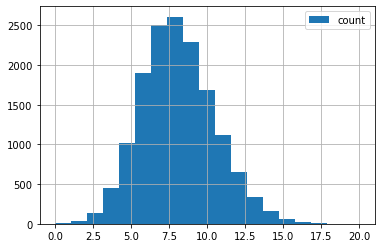

In [5]:
numFSPs_df = pd.DataFrame({'count' : df.groupby( [ "event"] ).size()}).reset_index()
minFSPs = numFSPs_df["count"].min()
maxFSPs = numFSPs_df["count"].max()


print("maxFSPs:",maxFSPs)
print("minFSPs:",minFSPs)

bins = np.linspace(0, maxFSPs, maxFSPs)
numFSPs_df["count"].hist(bins=bins, legend=True)


In [ ]:
for i in range(3):
    evNum = i+1
    print("event",evNum)
    print("# FSPs:",len(df[df.event == evNum]))
    print("# pions:",len(df[(df.event == evNum) & (abs(df.mcPDG) == 211)]))
    print("# kaons:",len(df[(df.event == evNum) & (abs(df.mcPDG) == 321)]))
    print("# gammas:",len(df[(df.event == evNum) & (abs(df.mcPDG) == 22)]))
    print('\n')
    
    

In [ ]:
print(len(df[df.event == 1]))
df[df.event == 1]